In [2]:
# notebooks/3_CNN_Spectrogram_Classifier_v2.ipynb

Using device: cpu
Epoch 1/50, Train Loss: 2.4733, Val Loss: 1.8443
Saved best model at epoch 1 with val loss 1.8443
Epoch 2/50, Train Loss: 1.7577, Val Loss: 1.6278
Saved best model at epoch 2 with val loss 1.6278
Epoch 3/50, Train Loss: 1.6429, Val Loss: 1.5187
Saved best model at epoch 3 with val loss 1.5187
Epoch 4/50, Train Loss: 1.5516, Val Loss: 1.5134
Saved best model at epoch 4 with val loss 1.5134
Epoch 5/50, Train Loss: 1.4975, Val Loss: 1.4482
Saved best model at epoch 5 with val loss 1.4482
Epoch 6/50, Train Loss: 1.4718, Val Loss: 1.4333
Saved best model at epoch 6 with val loss 1.4333
Epoch 7/50, Train Loss: 1.4402, Val Loss: 1.4375
Epoch 8/50, Train Loss: 1.4117, Val Loss: 1.3966
Saved best model at epoch 8 with val loss 1.3966
Epoch 9/50, Train Loss: 1.3853, Val Loss: 1.4124
Epoch 10/50, Train Loss: 1.3753, Val Loss: 1.3610
Saved best model at epoch 10 with val loss 1.3610
Epoch 11/50, Train Loss: 1.3175, Val Loss: 1.3523
Saved best model at epoch 11 with val loss 1.352

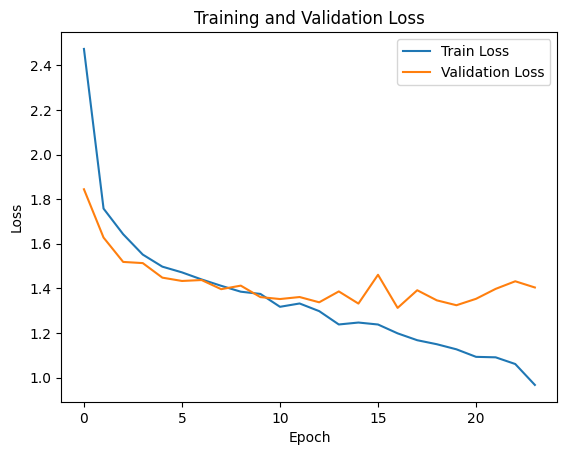

               precision    recall  f1-score   support

   Electronic       0.46      0.63      0.54       145
 Experimental       0.44      0.56      0.49       139
         Folk       0.47      0.70      0.56       139
      Hip-Hop       0.75      0.59      0.66       155
 Instrumental       0.59      0.43      0.50       164
International       0.62      0.59      0.60       165
          Pop       0.38      0.19      0.25       150
         Rock       0.61      0.62      0.61       143

     accuracy                           0.54      1200
    macro avg       0.54      0.54      0.53      1200
 weighted avg       0.54      0.54      0.53      1200



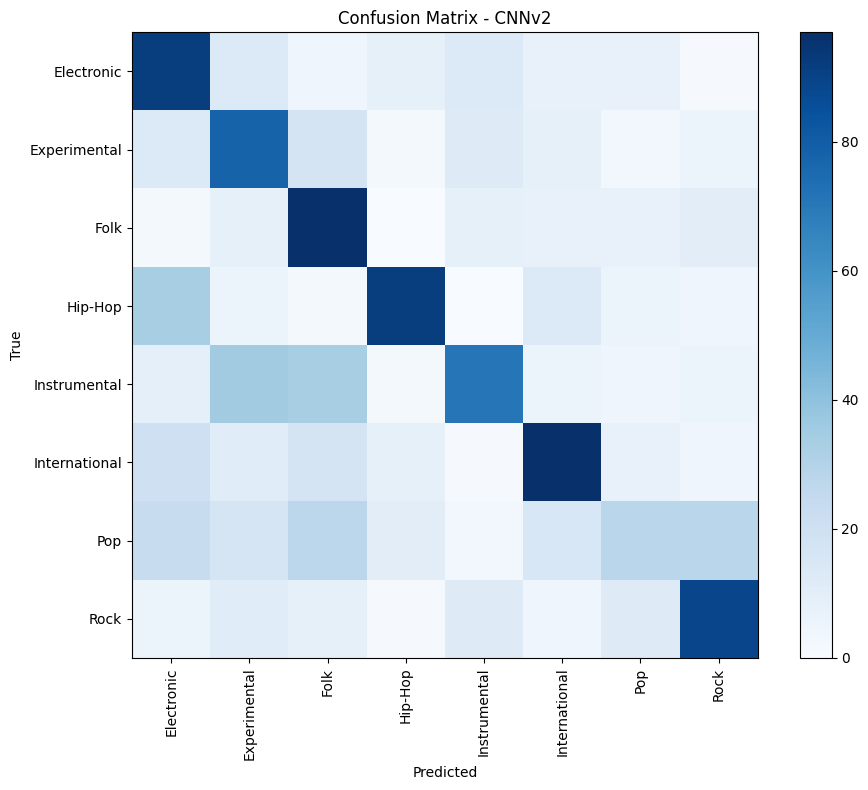

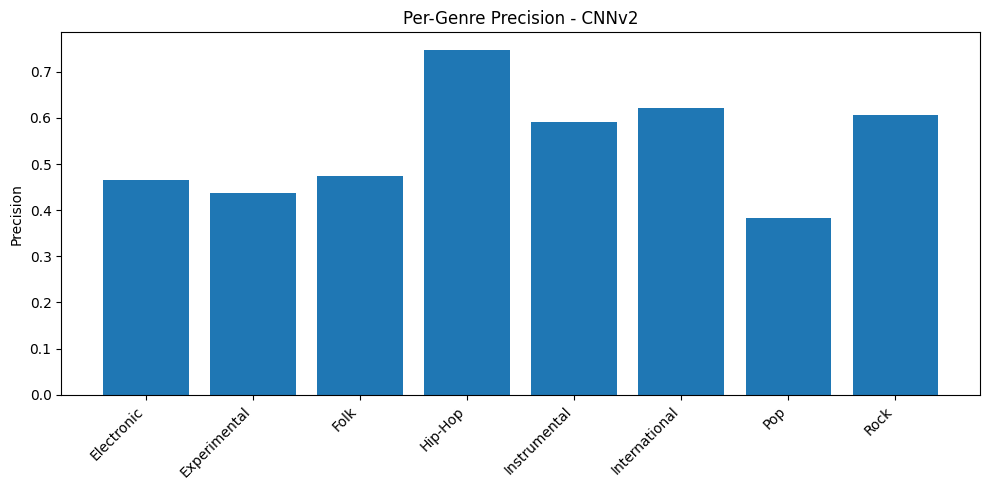

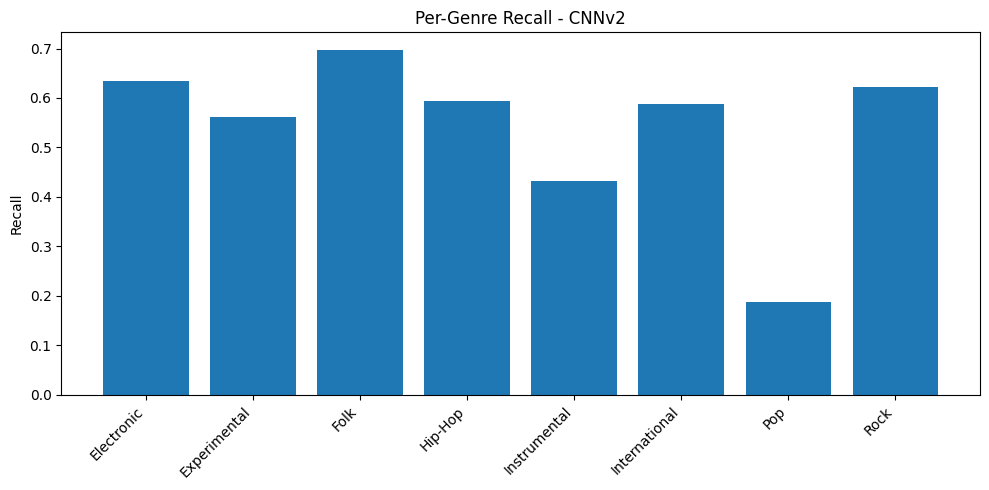

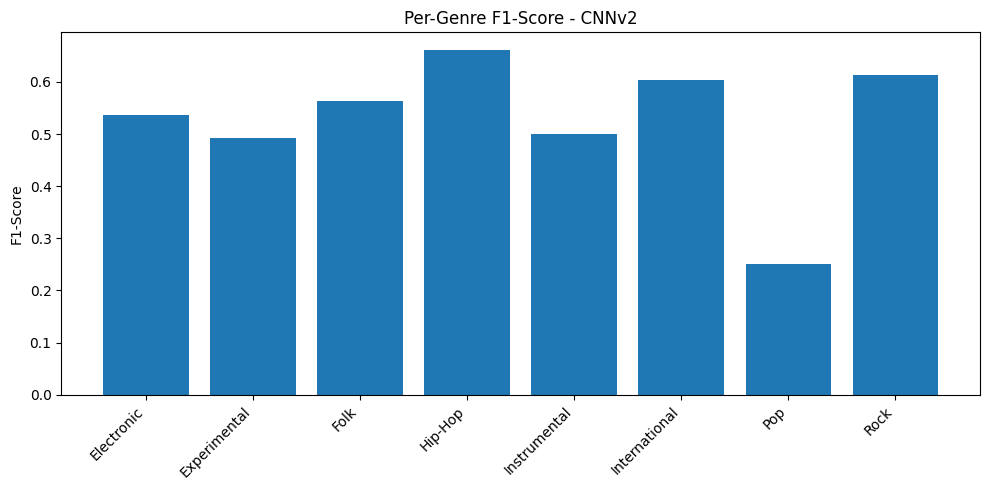

In [ ]:
# notebooks/CNN_Spectrogram_Classifier_v2.ipynb
# Aditya

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")


DATA_DIR = "../spectrograms"

BATCH_SIZE = 128

IMG_SIZE = 128

EPOCHS = 50

MODEL_SAVE_PATH = "../models/best_cnnv2_model.pth"

INFERENCE_BUNDLE_PATH = "../models/cnnv2_inference_bundle.pth"

REPORT_DIR = "../reports/CNNv2_Spectrogram_Classifier"

os.makedirs(REPORT_DIR, exist_ok=True)

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),

])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),

])


full_dataset = datasets.ImageFolder(DATA_DIR)
class_names = full_dataset.classes
num_classes = len(class_names)

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


class CNNv2(nn.Module):

    def __init__(self, num_classes):
        super(CNNv2, self).__init__()    
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )


    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc_block(x)
        return x


model = CNNv2(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5)


train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 7
early_stop_counter = 0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    scheduler.step(avg_val_loss)
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"Saved best model at epoch {epoch+1} with val loss {avg_val_loss:.4f}")
        early_stop_counter = 0
    else:

        early_stop_counter += 1

        if early_stop_counter >= patience:

            print(f"Early stopping triggered at epoch {epoch+1}. Best val loss: {best_val_loss:.4f}")

            break


# Save final model bundle

torch.save({

    'model_state_dict': model.state_dict(),

    'class_names': class_names,

    'transform': test_transform,

    'img_size': IMG_SIZE,

}, INFERENCE_BUNDLE_PATH)

print(f"Saved inference bundle to {INFERENCE_BUNDLE_PATH}")



plt.plot(train_losses, label='Train Loss')

plt.plot(val_losses, label='Validation Loss')

plt.xlabel('Epoch')

plt.ylabel('Loss')

plt.title('Training and Validation Loss')

plt.legend()

plt.savefig(os.path.join(REPORT_DIR, "cnnv2_loss_curve.png"))

plt.show()



model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval()


y_true = []

y_pred = []


with torch.no_grad():

    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)

        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.numpy())

        y_pred.extend(preds.cpu().numpy())


# Classification report

report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

with open(os.path.join(REPORT_DIR, "cnnv2_classification_report.txt"), "w") as f:

    f.write(report)


# Confusion matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))

plt.imshow(cm, interpolation='nearest', cmap='Blues')

plt.colorbar()

plt.xticks(np.arange(num_classes), class_names, rotation=90)

plt.yticks(np.arange(num_classes), class_names)

plt.xlabel('Predicted')

plt.ylabel('True')

plt.title('Confusion Matrix - CNNv2')

plt.tight_layout()

plt.savefig(os.path.join(REPORT_DIR, "cnnv2_confusion_matrix.png"))

plt.show()


# Per-genre metrics

precision, recall, f1, support = precision_recall_fscore_support(

    y_true, y_pred, labels=range(num_classes), zero_division=0)


for metric_name, values in zip(["Precision", "Recall", "F1-Score"], [precision, recall, f1]):

    plt.figure(figsize=(10,5))

    plt.bar(class_names, values)

    plt.ylabel(metric_name)
    plt.title(f"Per-Genre {metric_name} - CNNv2")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    filename = f"cnnv2_per_genre_{metric_name.lower().replace('-', '_')}.png"
    plt.savefig(os.path.join(REPORT_DIR, filename))
    plt.show()